In [1]:
import xarray as xr
import pandas as pd
import numpy as np

In [2]:
ds = xr.open_dataset("../output/grids/a3d_grids.nc")
var='swe'
ds

<xarray.Dataset>
Dimensions:                (easting: 168, northing: 107, time: 16)
Coordinates:
  * time                   (time) datetime64[ns] 1980-01-01T01:00:00 ... 1980-01-01T16:00:00
  * northing               (northing) float32 -109000.0 -108000.0 ... -3000.0
  * easting                (easting) float32 -1542000.0 ... -1375000.0
Data variables:
    dw                     (time, northing, easting) float32 ...
    ET                     (time, northing, easting) float32 ...
    snd                    (time, northing, easting) float32 ...
    rlds                   (time, northing, easting) float32 ...
    rsds                   (time, northing, easting) float32 ...
    MS_SNOWPACK_RUNOFF     (time, northing, easting) float32 ...
    pr                     (time, northing, easting) float32 ...
    hur                    (time, northing, easting) float32 ...
    snow_density           (time, northing, easting) float32 ...
    SFC_SUBL               (time, northing, easting) float32 ...
    SURF_ALB               (time, northing, easting) float32 ...
    swe                    (time, northing, easting) float32 ...
    ta                     (time, northing, easting) float32 ...
    TOP_ALB                (time, northing, easting) float32 ...
    TSG                    (time, northing, easting) float32 ...
    ts                     (time, northing, easting) float32 ...
    ws                     (time, northing, easting) float32 ...
    VW_DRIFT               (time, northing, easting) float32 ...
    WINDEROSIONDEPOSITION  (time, northing, easting) float32 ...
Attributes:
    date_created:              2020-08-28
    creator_name:              erke2265
    source:                    MeteoIO-2.81
    history:                   2020-08-28T23:53:20Z, erke2265@shas0103.rc.int...
    keywords_vocabulary:       AGU Index Terms
    keywords:                  Cryosphere, Mass Balance, Energy Balance, Atmo...
    title:                     Gridded data for various parameters and timesteps
    institution:               colorado.edu
    product_version:           1.0
    Conventions:               CF-1.6,ACDD-1.3
    standard_name_vocabulary:  CF-1.6
    cdm_data_type:             Grid
    geospatial_bounds_crs:     EPSG:3031
    geospatial_bounds:         Polygon ((-1542000.0000000000 -109000.00000000...

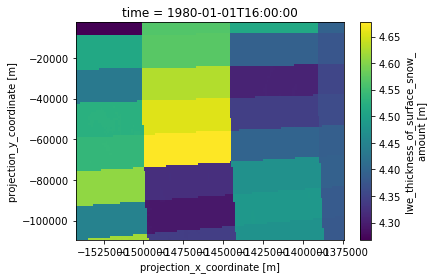

In [3]:
ds[var][-1,:,:].plot()

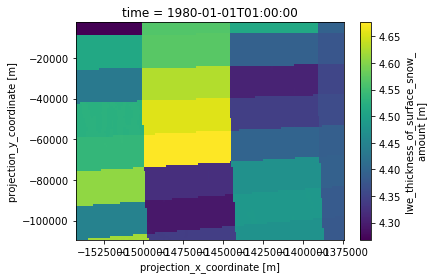

In [4]:
ds[var][0,:,:].plot()

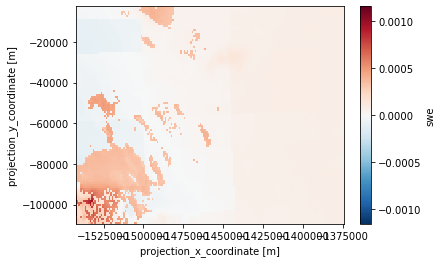

In [5]:
dswe = ds[var][-1,:,:] - ds[var][0,:,:]
dswe.plot()

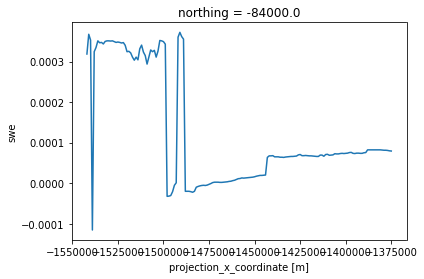

In [6]:
dswe.sel(northing=-84000).plot()

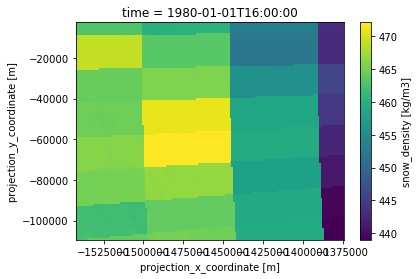

In [7]:
ds['snow_density'][-1,:,:].plot()

# Compare delta SWE to sum of mass balance components. Units of mm water equivalent
### For MB: Peak is in lower left, but for delta swe that peak does not exist. Are the grids flipped?

Mean Delta SWE (mm) = 0.070704974


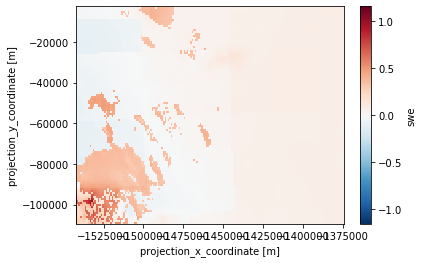

In [8]:
# Delta SWE
dswe = ds['swe'].isel(time=-1) - ds['swe'].isel(time=0)
dswe = dswe * 1000 # Convert from m to mm water equivalent
dswe.plot()
dswe_mean = dswe.mean(dim='easting').mean(dim='northing').values
print("Mean Delta SWE (mm) = " + str(dswe_mean))

Mean Sum of Mass Balance Components (mm) = 0.368488
Mean ratio between Mass balance and delta SWE = 5.211628


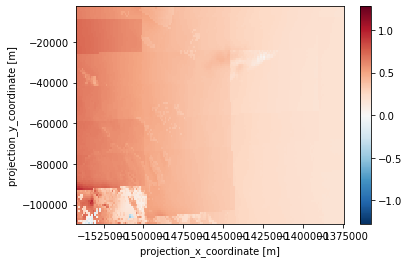

In [9]:
# Sum of mass balance components (note that only precipitation and sublimation are currently non-zero)
mb = ds['pr'].sum(dim='time') + ds['ET'].sum(dim='time') + \
    ds['WINDEROSIONDEPOSITION'].sum(dim='time') + ds['MS_SNOWPACK_RUNOFF'].sum(dim='time')
mb.plot()
mb_mean = mb.mean(dim='easting').mean(dim='northing').values


print("Mean Sum of Mass Balance Components (mm) = " + str(mb_mean))
print("Mean ratio between Mass balance and delta SWE = " + str(mb_mean / dswe_mean))

# Plot the ratio and difference between delta swe and mass balance components

<xarray.DataArray ()>
array(inf, dtype=float32)


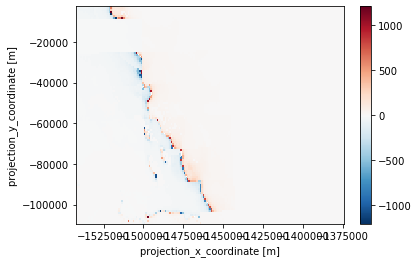

In [10]:
ratio = mb / dswe
ratio.plot()
print(ratio.mean(dim='easting').mean(dim='northing'))

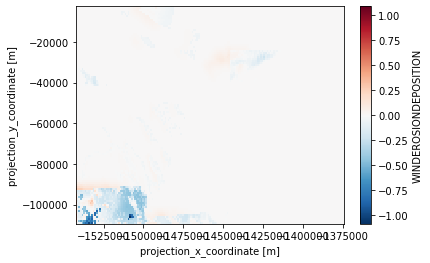

In [11]:
ds['WINDEROSIONDEPOSITION'].sum(dim='time').plot()
